In [1]:
# %edit
# %load_ext autoreload
# %autoreload 2

IPython will make a temporary file named: C:\Users\yhu42\AppData\Local\Temp\ipython_edit_z9m7pilk\ipython_edit_r5qj43fa.py


In [5]:
#import openai
# import jax.numpy as jnp
# from jax.scipy.special import logsumexp
from typing import Optional, Tuple, Dict
import numpy as np
import pandas as pd
import time
# import hydra
# from cdt.causality.pairwise import RECI
import os
# from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer
import re
from diskcache import Cache
from tqdm import tqdm
import json
import time

#import torch

#from transformers import pipeline, set_seed
#from transformers import GPT2Tokenizer, GPT2Model

from multiprocessing import Pool
from haversine import haversine, Unit

from utils import *

## Load result

In [6]:
res_dict_list = read_res_file("result/placerecognize_GPT-4_22examples_conversational.json")
df = pd.DataFrame.from_records(res_dict_list)
df = df[["tweetFileID","tweetFulltext","tweetAnnotation","answer"]]
df

,tweetFileID,tweetFulltext,tweetAnnotation,answer
0,data/0.txt,Houston HoustonFlood the intersection of I-45 ...,"[{'locationDesc': 'Houston', 'locationCate': '...",C9: Houston; C5: the intersection of I-45 & N....
1,data/1.txt,"HarveyStorm over Austin, TX at 8: 00 AM CDT vi...","[{'locationDesc': 'Austin', 'locationCate': 'C...",C9: Austin; C9: TX
2,data/10.txt,"Harvey Elderly dad, brother, daughter and 3yr ...","[{'locationDesc': 'Magnolia Estates', 'locatio...",C8: Magnolia Estates; C1: 101 Normandy St
3,data/100.txt,Rockport about to get hit by 130 mph winds aft...,"[{'locationDesc': 'Rockport', 'locationCate': ...",C9: Rockport
4,data/101.txt,Rockport close to re-entering Harvey southern ...,"[{'locationDesc': 'Rockport', 'locationCate': ...",C9: Rockport
...,...,...,...,...
995,data/995.txt,"No, this is NOT a river. It is a Houston Freew...","[{'locationDesc': 'N I-45 a Main Street', 'loc...",C9: Houston; C3: N I-45; C2: Main Street
996,data/996.txt,Taking Harvey2017 and Irma2017 donations at 61...,[{'locationDesc': '6150 South Park location in...,C1: 6150 South Park location in Hamburg; C9: B...
997,data/997.txt,Teachers from the Houston area are collecting ...,"[{'locationDesc': 'Houston', 'locationCate': '...",C9: Houston; C7: Sara Park; C9: Tomahawk
998,data/998.txt,Teen boy was rescued and his mother was presen...,"[{'locationDesc': 'South Shore Park', 'locatio...",C7: South Shore Park


## Confusion Matrix

In [8]:
# function for creating the matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz

"""
Function to create confusion matrix
"""


def make_confusion_matrix(cf,
                          group_names=None,
                          x_categories='auto',
                          y_categories = 'auto',
                          count=True,
                          percent=True,
                          cbar=False,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    cfn = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    for x in range(len(cfn)):
        for y in range(len(cfn[x])):
            if(np.isnan(cfn[x][y])):
                cfn[x][y] = 0

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = []
        for category in range(len(cf)):
            for row in range(len(cf[category])):
                if(np.isnan(row)):
                    group_percentages.append("0.0%")
                else:
                    group_percentages.append("{0:.2%}".format(cf[category][row]/sum(cf[category])))
        #group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        #accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = ""
            #"\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cfn,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=x_categories,yticklabels=y_categories, linewidths=0.5, linecolor='black',clip_on=False)
    
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    if xyplotlabels:
        plt.ylabel('Ground Truth')
        plt.xlabel('Predicted')
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title + stats_text)
        
    plt.savefig("confusion.png", dpi=300, format='png',bbox_inches='tight')

C:\Users\yhu42\yhu42\IDE\Anaconda\envs\GEO514\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [15]:
# exact matching
def get_filtered_list():
    filtered_list = []
    for fileName in os.listdir("training_tweets"):
        filtered_list.append(fileName)
        
    return filtered_list


filtered_list = get_filtered_list()
    
# create values for the confusion matrix
total_valid_cate = 11

result_dict={}
df = df.reset_index()
for index, row in df.iterrows():

    tweetID = row["tweetFileID"].replace("data/","")
    if tweetID in filtered_list:
        print("in training")
        continue


    this_prediction_list = row['answer'].split(";")

    if type(row['tweetAnnotation']) == str:
        this_annotation_list = json.loads(row['tweetAnnotation'])
    else:
        this_annotation_list = row['tweetAnnotation']


    print(row['tweetFulltext'])
    print(str(this_prediction_list).encode("utf-8"))
    print(this_annotation_list)
    print("---")

    for this_annotation_item in this_annotation_list:
        this_annotation_cate = this_annotation_item['locationCate']
        this_annotation_desc = this_annotation_item['locationDesc']

        matched = False
        for this_prediction_item in this_prediction_list:
            this_prediction_item_cleaned = this_prediction_item.strip(" \n")
            this_prediction_result = this_prediction_item_cleaned.split(":")

            # check to ensure this is a valid prediction
            if len(this_prediction_result) != 2:
                this_prediction_list.remove(this_prediction_item)
                continue
            # check to ensure this is a valid prediction

            this_prediction_cate = this_prediction_result[0]
            this_prediction_desc = this_prediction_result[1].strip()
            this_prediction_cate_number = int(this_prediction_cate[1:])

            if this_annotation_desc.lower() == this_prediction_desc.lower():#(fuzz.ratio(this_annotation_desc.lower(), this_prediction_desc.lower()) >= 75) and (this_prediction_cate_number <= total_valid_cate):
                combined_cate = this_annotation_cate+this_prediction_cate
                if combined_cate in result_dict.keys():
                    result_dict[combined_cate] = result_dict[combined_cate] + 1
                else:
                    result_dict[combined_cate] = 1

                this_prediction_list.remove(this_prediction_item)  # remove this item from the prediction list once a match is found
                matched = True
                break


        # add this annotation to the true dictionary
#         if this_annotation_cate == "":
#             print(this_annotation_item)
#             print(row)
        if not matched:
            combined_cate = this_annotation_cate+"C12"
            if combined_cate in result_dict.keys():
                result_dict[combined_cate] = result_dict[combined_cate] + 1
            else:        
                result_dict[combined_cate] = 1



    # those that remain in the prediction list are false positives, i.e., predicted
    for this_prediction_item in this_prediction_list:
        this_prediction_item_cleaned = this_prediction_item.strip(" \n")
        this_prediction_result = this_prediction_item_cleaned.split(":")

        # check to ensure this is a valid prediction
        if len(this_prediction_result) != 2:
            this_prediction_list.remove(this_prediction_item)
            continue
        # check to ensure this is a valid prediction

        this_prediction_cate = this_prediction_result[0].strip()
        this_prediction_desc = this_prediction_result[1].strip()

        if not this_prediction_cate.startswith('C'):
            this_prediction_list.remove(this_prediction_item)
            continue

        this_prediction_cate_number = int(this_prediction_cate[1:])

        if this_prediction_cate_number <= total_valid_cate:
            combined_cate = "C12"+ this_prediction_cate
        else:
            combined_cate = "C12C12"

        if combined_cate in result_dict.keys():
            result_dict[combined_cate] = result_dict[combined_cate] + 1
        else:        
            result_dict[combined_cate] = 1

    



# after all the counts are done, calculate the matrix

matrix_size = total_valid_cate+1
cf_matrix = np.zeros((matrix_size,matrix_size))

for row_num in range(matrix_size):
    for col_num in range(matrix_size):
        value_key = "C"+str(row_num+1)+"C"+str(col_num+1)
        if value_key in result_dict.keys():
            value = result_dict[value_key]
        else:
            value = 0
        cf_matrix[row_num,col_num] = value


cf_matrix


Houston HoustonFlood the intersection of I-45 & N. Main Street
b"['C9: Houston', ' C5: the intersection of I-45 & N. Main Street']"
[{'locationDesc': 'Houston', 'locationCate': 'C9', 'startIndex': 0, 'endIndex': 7}, {'locationDesc': 'I-45 & N. Main Street', 'locationCate': 'C5', 'startIndex': 41, 'endIndex': 62}]
---
HarveyStorm over Austin, TX at 8: 00 AM CDT via Weather Underground
b"['C9: Austin', ' C9: TX']"
[{'locationDesc': 'Austin', 'locationCate': 'C9', 'startIndex': 17, 'endIndex': 23}, {'locationDesc': 'TX', 'locationCate': 'C9', 'startIndex': 25, 'endIndex': 27}]
---
Harvey Elderly dad, brother, daughter and 3yr old grandson no power, food. Senior living community, Magnolia Estates, at 101 Normandy St
b"['C8: Magnolia Estates', ' C1: 101 Normandy St']"
[{'locationDesc': 'Magnolia Estates', 'locationCate': 'C7', 'startIndex': 100, 'endIndex': 116}, {'locationDesc': '101 Normandy St', 'locationCate': 'C1', 'startIndex': 121, 'endIndex': 136}]
---
Rockport about to get hit by 1

b"['C9: Bastrop', ' C2: Fawcett St.', ' C9: Smithville']"
[{'locationDesc': 'Fawcett St.', 'locationCate': 'C2', 'startIndex': 102, 'endIndex': 113}, {'locationDesc': 'Smithville', 'locationCate': 'C9', 'startIndex': 117, 'endIndex': 127}]
---
NINE families are missing from a demolished mobile home park in Rockport HurricaneHarve
b"['C7: mobile home park', ' C9: Rockport']"
[{'locationDesc': 'Rockport', 'locationCate': 'C9', 'startIndex': 64, 'endIndex': 72}]
---
Near Watterson rd. Donation station In Bastrop City. Harvey HurricaneHarvey
b"['C2: Watterson rd.', ' C9: Bastrop City']"
[{'locationDesc': 'Watterson rd', 'locationCate': 'C2', 'startIndex': 5, 'endIndex': 17}, {'locationDesc': 'Bastrop City', 'locationCate': 'C9', 'startIndex': 39, 'endIndex': 51}]
---
Neighborhood storm drains near Nederland Ave already busy handling the accumulation from spotty rain bursts Harvey â€¦
b"['C5: Neighborhood storm drains near Nederland Ave']"
[{'locationDesc': 'Nederland Ave', 'locationCate': 

array([[200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
         61.],
       [  0., 112.,   0.,   0.,   6.,   0.,   0.,   0.,   1.,   0.,   0.,
        105.],
       [  0.,   0.,  12.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         14.],
       [  0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.],
       [  0.,   5.,   1.,   0.,  49.,   2.,   0.,   0.,   0.,   0.,   0.,
         47.],
       [  0.,   0.,   0.,   0.,   0.,  37.,   1.,   0.,   3.,  11.,   0.,
          9.],
       [  0.,  12.,   0.,   0.,   0.,   3., 139.,   9.,   3.,  19.,   0.,
         38.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,  49.,   0.,   0.,   0.,
         13.],
       [  0.,   0.,   0.,   0.,   3.,   0.,   2.,   4., 444.,  49.,   0.,
        208.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,
          1.],
       [  0.,   2.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   1.,
          3.],
       [ 67.,  70.,  

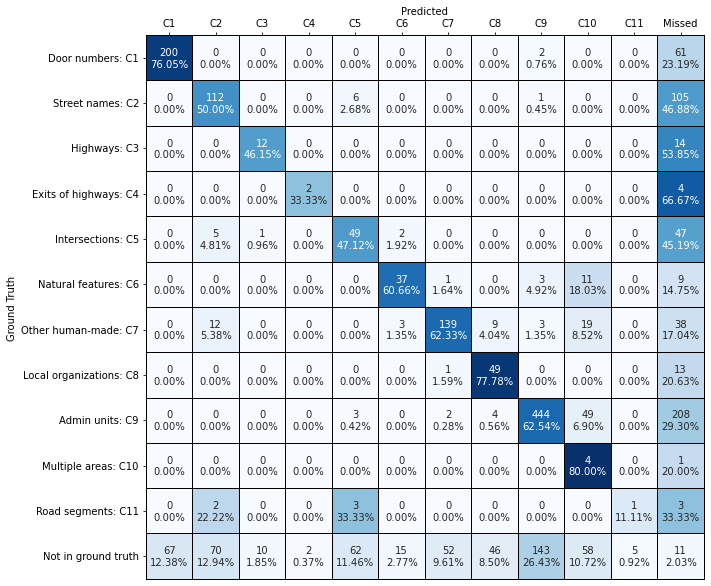

In [16]:
y_categories = ["Door numbers: C1", "Street names: C2", "Highways: C3", "Exits of highways: C4", "Intersections: C5", "Natural features: C6", "Other human-made: C7", "Local organizations: C8", "Admin units: C9", "Multiple areas: C10", "Road segments: C11", "Not in ground truth"]
x_categories = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","Missed"]
#categories = ["C1", "C2", "Missed"]
make_confusion_matrix(cf = cf_matrix, x_categories = x_categories,y_categories = y_categories, count = True, figsize=(10, 10))

In [20]:
# Relaxed matching with 75% overlapping

from fuzzywuzzy import fuzz

def get_filtered_list():
    filtered_list = []
    for fileName in os.listdir("training_tweets"):
        filtered_list.append(fileName)
        
    return filtered_list


filtered_list = get_filtered_list()
    
# create values for the confusion matrix
total_valid_cate = 11

result_dict={}
#df = df.reset_index()
for index, row in df.iterrows():

    tweetID = row["tweetFileID"].replace("data/","")
    if tweetID in filtered_list:
        print("in training")
        continue


    this_prediction_list = row['answer'].split(";")

    if type(row['tweetAnnotation']) == str:
        this_annotation_list = json.loads(row['tweetAnnotation'])
    else:
        this_annotation_list = row['tweetAnnotation']


    print(row['tweetFulltext'])
    print(str(this_prediction_list).encode("utf-8"))
    print(this_annotation_list)
    print("---")

    for this_annotation_item in this_annotation_list:
        this_annotation_cate = this_annotation_item['locationCate']
        this_annotation_desc = this_annotation_item['locationDesc']

        matched = False
        for this_prediction_item in this_prediction_list:
            this_prediction_item_cleaned = this_prediction_item.strip(" \n")
            this_prediction_result = this_prediction_item_cleaned.split(":")

            # check to ensure this is a valid prediction
            if len(this_prediction_result) != 2:
                this_prediction_list.remove(this_prediction_item)
                continue
            # check to ensure this is a valid prediction

            this_prediction_cate = this_prediction_result[0]
            this_prediction_desc = this_prediction_result[1].strip()
            this_prediction_cate_number = int(this_prediction_cate[1:])

            if fuzz.ratio(this_annotation_desc.lower(), this_prediction_desc.lower()) >= 75:
                combined_cate = this_annotation_cate+this_prediction_cate
                if combined_cate in result_dict.keys():
                    result_dict[combined_cate] = result_dict[combined_cate] + 1
                else:
                    result_dict[combined_cate] = 1

                this_prediction_list.remove(this_prediction_item)  # remove this item from the prediction list once a match is found
                matched = True
                break


        # add this annotation to the true dictionary
#         if this_annotation_cate == "":
#             print(this_annotation_item)
#             print(row)
        if not matched:
            combined_cate = this_annotation_cate+"C12"
            if combined_cate in result_dict.keys():
                result_dict[combined_cate] = result_dict[combined_cate] + 1
            else:        
                result_dict[combined_cate] = 1



    # those that remain in the prediction list are false positives, i.e., predicted
    for this_prediction_item in this_prediction_list:
        this_prediction_item_cleaned = this_prediction_item.strip(" \n")
        this_prediction_result = this_prediction_item_cleaned.split(":")

        # check to ensure this is a valid prediction
        if len(this_prediction_result) != 2:
            this_prediction_list.remove(this_prediction_item)
            continue
        # check to ensure this is a valid prediction

        this_prediction_cate = this_prediction_result[0].strip()
        this_prediction_desc = this_prediction_result[1].strip()

        if not this_prediction_cate.startswith('C'):
            this_prediction_list.remove(this_prediction_item)
            continue

        this_prediction_cate_number = int(this_prediction_cate[1:])

        if this_prediction_cate_number <= total_valid_cate:
            combined_cate = "C12"+ this_prediction_cate
        else:
            combined_cate = "C12C12"

        if combined_cate in result_dict.keys():
            result_dict[combined_cate] = result_dict[combined_cate] + 1
        else:        
            result_dict[combined_cate] = 1

    



# after all the counts are done, calculate the matrix

matrix_size = total_valid_cate+1
cf_matrix = np.zeros((matrix_size,matrix_size))

for row_num in range(matrix_size):
    for col_num in range(matrix_size):
        value_key = "C"+str(row_num+1)+"C"+str(col_num+1)
        if value_key in result_dict.keys():
            value = result_dict[value_key]
        else:
            value = 0
        cf_matrix[row_num,col_num] = value



Houston HoustonFlood the intersection of I-45 & N. Main Street
b"['C9: Houston', ' C5: the intersection of I-45 & N. Main Street']"
[{'locationDesc': 'Houston', 'locationCate': 'C9', 'startIndex': 0, 'endIndex': 7}, {'locationDesc': 'I-45 & N. Main Street', 'locationCate': 'C5', 'startIndex': 41, 'endIndex': 62}]
---
HarveyStorm over Austin, TX at 8: 00 AM CDT via Weather Underground
b"['C9: Austin', ' C9: TX']"
[{'locationDesc': 'Austin', 'locationCate': 'C9', 'startIndex': 17, 'endIndex': 23}, {'locationDesc': 'TX', 'locationCate': 'C9', 'startIndex': 25, 'endIndex': 27}]
---
Harvey Elderly dad, brother, daughter and 3yr old grandson no power, food. Senior living community, Magnolia Estates, at 101 Normandy St
b"['C8: Magnolia Estates', ' C1: 101 Normandy St']"
[{'locationDesc': 'Magnolia Estates', 'locationCate': 'C7', 'startIndex': 100, 'endIndex': 116}, {'locationDesc': '101 Normandy St', 'locationCate': 'C1', 'startIndex': 121, 'endIndex': 136}]
---
Rockport about to get hit by 1

Glad to see our family's house on Water Street is still standing! Harvey Rockport
b"['C2: Water Street', ' C9: Rockport']"
[{'locationDesc': 'Water Street', 'locationCate': 'C2', 'startIndex': 34, 'endIndex': 46}, {'locationDesc': 'Rockport', 'locationCate': 'C9', 'startIndex': 73, 'endIndex': 81}]
---
Frazer Pike Road Church gathering donations for HurricaneHarvey relief @ Chantilly Home Depot until Wednesday.
b"['C8: Frazer Pike Road Church', ' C7: Chantilly Home Depot']"
[{'locationDesc': 'Frazer Pike Road Church', 'locationCate': 'C8', 'startIndex': 0, 'endIndex': 23}]
---
GOP sent out an email urging donations to Red Cross, Salvation Army, United Way and animal rescue orgs in TX and LA â€¦
b"['C9: TX', ' C9: LA']"
[{'locationDesc': 'TX', 'locationCate': 'C9', 'startIndex': 106, 'endIndex': 108}, {'locationDesc': 'LA', 'locationCate': 'C9', 'startIndex': 113, 'endIndex': 115}]
---
Good morning from Kroger on Killian Rd. We're raising cash for the HurricaneHarvey victims. â€¦
b"['C2

Willow Curry and her 2 aunts have been waiting for hours with no relief. 8130 Snowden St Houston TX 77028 harveyhouston HurricaneHarve
b"['C1: 8130 Snowden St Houston TX 77028']"
[{'locationDesc': '8130 Snowden St Houston TX 77028', 'locationCate': 'C1', 'startIndex': 73, 'endIndex': 105}]
---
Woman stuck with newborn in house w/rising H2O. 11911 Hillcroft Ave. 77035. RT/Help. HTX HurricaneHarvey
b"['C1: 11911 Hillcroft Ave. 77035']"
[{'locationDesc': '11911 Hillcroft Ave. 77035', 'locationCate': 'C1', 'startIndex': 48, 'endIndex': 74}]
---
Yale Street and I-10 feeder emerges overnight as WhiteOakBayou water levels go down! More HurricaneHarvey pics: â€¦
b"['C2: Yale Street', ' C3: I-10 feeder', ' C6: WhiteOakBayou']"
[{'locationDesc': 'Yale Street and I-10', 'locationCate': 'C5', 'startIndex': 0, 'endIndex': 20}, {'locationDesc': 'WhiteOakBayou', 'locationCate': 'C6', 'startIndex': 49, 'endIndex': 62}]
---
Yale St @ I-10 by White Oak Bayou looking SE to downtown Houston (background );

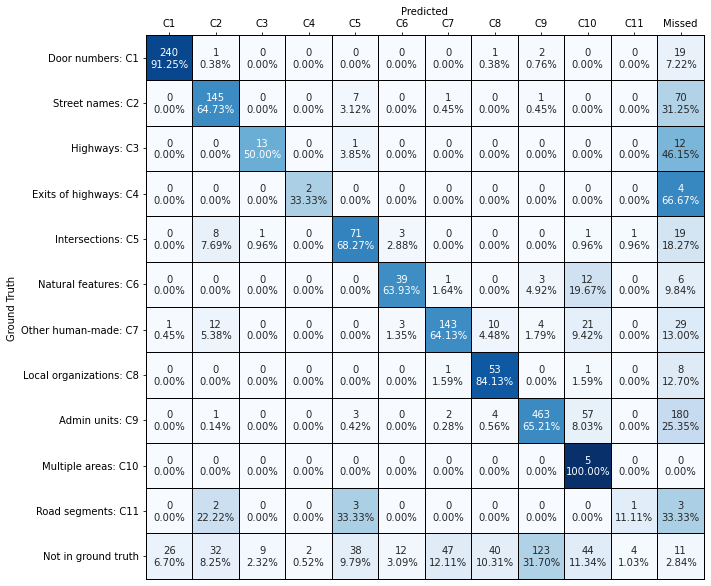

In [21]:
# matrix for fuzzy matching
y_categories = ["Door numbers: C1", "Street names: C2", "Highways: C3", "Exits of highways: C4", "Intersections: C5", "Natural features: C6", "Other human-made: C7", "Local organizations: C8", "Admin units: C9", "Multiple areas: C10", "Road segments: C11", "Not in ground truth"]
x_categories = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","Missed"]
#categories = ["C1", "C2", "Missed"]
make_confusion_matrix(cf = cf_matrix, x_categories = x_categories,y_categories = y_categories, count = True, figsize=(10, 10))

## Create Precision, Recall, and F score bars

In [1]:
import pandas as pd

df = pd.read_csv("categorized_combined.csv")
df.head()

,Model,Category,Precision,Recall,Fscore
0,Fine-tuned-BERT,C1,0.00000,0.000000,0.000000
1,Fine-tuned-BERT,C2,0.01791,0.027149,0.021582
2,Fine-tuned-BERT,C3,0.00000,0.000000,0.000000
3,Fine-tuned-BERT,C4,0.00000,0.000000,0.000000
4,Fine-tuned-BERT,C5,0.00000,0.000000,0.000000


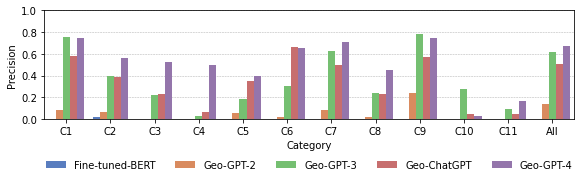

In [2]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt
 
# read a titanic.csv file
# from seaborn library
#df = sns.load_dataset('titanic')
 
 

 
# Show the plot
plt.figure(figsize=(9.5,2))
# who v/s fare barplot
ax = sns.barplot(x = 'Category',
            y = 'Precision',
            hue = 'Model',
            data = df, order = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","All"], hue_order=["Fine-tuned-BERT","Geo-GPT-2","Geo-GPT-3","Geo-ChatGPT","Geo-GPT-4"], palette="muted", zorder=3)
#plt.show()
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -.55),
    ncol=5,
    title=None, frameon=False,
)
ax.grid(axis='y',linestyle='--', linewidth=0.5, zorder=0)
plt.ylim([0,1])
plt.savefig("Precision.png", dpi=300, format='png',bbox_extra_artists=(ax,), bbox_inches='tight')

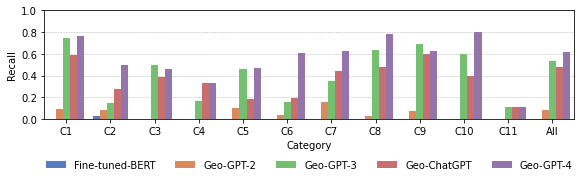

In [3]:
# Recall plot
plt.figure(figsize=(9.5,2))
# who v/s fare barplot
ax=sns.barplot(x = 'Category',
            y = 'Recall',
            hue = 'Model',
            data = df, order = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","All"], hue_order=["Fine-tuned-BERT","Geo-GPT-2","Geo-GPT-3","Geo-ChatGPT","Geo-GPT-4"], palette="muted", zorder=5)
#plt.show()
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -.55),
    ncol=5,
    title=None, frameon=False,
)
plt.ylim([0,1])
ax.grid(axis='y',linestyle='--', linewidth=0.5, zorder=0)
plt.savefig("Recall.png", dpi=300, format='png',bbox_extra_artists=(ax,), bbox_inches='tight')



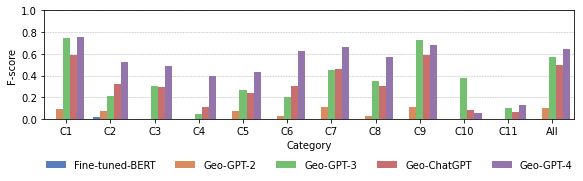

In [4]:
# Fscore plot
plt.figure(figsize=(9.5,2))

# who v/s fare barplot
ax = sns.barplot(x = 'Category',
            y = 'Fscore',
            hue = 'Model',
            data = df, order = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","All"], hue_order=["Fine-tuned-BERT","Geo-GPT-2","Geo-GPT-3","Geo-ChatGPT","Geo-GPT-4"], palette="muted", zorder=5)
#plt.show()
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylabel("F-score")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -.55),
    ncol=5,
    title=None, frameon=False,
)
ax.grid(axis='y',linestyle='--', linewidth=0.5, zorder=0)
plt.ylim([0,1])
plt.savefig("F-score.png", dpi=300, format='png',bbox_extra_artists=(ax,), bbox_inches='tight')
